In [1]:
import os
import numpy as np
import tifffile
from tqdm import tqdm


def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.

    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ]
    )

    tiff_sequence = tifffile.TiffSequence(tiff_files)

    # Get the total number of TIFF files
    total_files = len(tiff_files)

    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)

            # Update progress
            pbar.update(1)

    return np.array(volume)

c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.

    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)

    print("Saving complete.")

In [3]:
from pathlib import Path

folder1 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/5/bot_eq_aligned_centered"
)
folder2 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/5/top_eq_aligned_centered"
)

bot = read_sequence(folder1)
top = read_sequence(folder2)

# flip slices order in top volume
top = top[::-1]

Progress: 100%|██████████| 4506/4506 [00:08<00:00, 530.27it/s]


In [4]:
def find_candidates_slice(
    frameid, length, resolution, vol1shape, vol2shape, range_slices=200, show=False
):
    """
    Find the candidates for a given frameid, length and resolution.

    Args:
    frameid (int): Frame id of the first volume.
    length (int): Length of the sample scanned in two volumes in millimeters.
    resolution (int): Resolution of the scan.
    vol1shape (int): Number of slices in the first volume.
    vol2shape (int): Number of slices in the second volume.

    Returns:
    list: List of candidates to be the same slice in the second volume as frameid in the first.
    """

    # Calculate the number of slices needed to cover the length of the sample
    n_slices = int(length / resolution)

    # Calulate the remaining slices needed to cover the length of the sample
    remaining = n_slices - frameid

    # Calculate where should the first slice of he second volume be to fit the length of the sample
    start_vol2 = vol2shape - remaining

    # print all
    if show:
        print(
            f"frameid: {frameid}, n_slices: {n_slices}, remaining: {remaining}, start_vol2: {start_vol2}"
        )

    # define range
    start = np.clip(start_vol2 - range_slices // 2, a_min=0, a_max=None)
    end = np.clip(start_vol2 + range_slices // 2, a_min=None, a_max=vol2shape)

    # Create a list of candidates, all numbers in a range of 200 being start_vol2 the center
    candidates = [i for i in range(start, end)]

    # Create tuples of one candidate and the frameid
    return np.array([(frameid, candidate) for candidate in candidates])

In [38]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage import measure


# create a function that return the x and y spatial shift between two slices
def find_shift(s1, s2, show=False, top_threshold=255):
    """
    Find the x and y spatial shift between two slices.

    Args:
    slice1 (numpy.ndarray): First slice.
    slice2 (numpy.ndarray): Second slice.

    Returns:
    tuple: Tuple with the x and y shift.
    """
    # check if the slice is 8bit
    if s1.dtype != np.uint8:
        top_threshold = 65535

    # copy slices
    slice1 = s1.copy()
    slice2 = s2.copy()

    # make 0 every pixel above the threshold in each slice
    slice1[slice1 > top_threshold] = 0
    slice2[slice2 > top_threshold] = 0

    # autothreshold the slices using otsu
    thresh1 = threshold_otsu(slice1)
    thresh2 = threshold_otsu(slice2)

    # apply threshold to the slices
    slice1 = slice1 > thresh1
    slice2 = slice2 > thresh2

    # label the slices
    slice1 = measure.label(slice1)
    slice2 = measure.label(slice2)

    # get the largest component of each slice
    regprops1 = measure.regionprops(slice1)
    regprops2 = measure.regionprops(slice2)
    largest1 = regprops1[np.argmax([regprop.area for regprop in regprops1])].label
    largest2 = regprops2[np.argmax([regprop.area for regprop in regprops2])].label
    slice1[slice1 != largest1] = 0
    slice2[slice2 != largest2] = 0

    # calculate the cross correlation between the two slices
    corr = np.fft.fftshift(np.fft.fft2(slice1)) * np.fft.fftshift(
        np.fft.fft2(slice2).conj()
    )

    # calculate the inverse fourier transform of the cross correlation
    corr = np.fft.ifft2(corr)

    # calculate the shift in x and y
    shift = np.unravel_index(np.argmax(corr), corr.shape)

    # print all
    if show:
        print(f"shift: {shift}, corr.shape: {corr.shape}")

        # shift the second slice so it matches the first
        shifted = np.roll(slice2, shift[0], axis=0)
        shifted = np.roll(shifted, shift[1], axis=1)

        # plot the two slices using matplotlib
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(slice1, cmap="gray")
        ax[1].imshow(shifted, cmap="gray")
        plt.show()

    # return the shift in x and y
    return shift

In [50]:
from concurrent.futures import ThreadPoolExecutor


def shift_slice(args):
    """
    Shift a slice.

    Args:
    slice (numpy.ndarray): Slice to be shifted.
    shift (tuple): Tuple with the x and y shift.

    Returns:
    numpy.ndarray: Shifted slice.
    """
    # unpack args
    slice, shift = args
    # shift the slice
    shifted = np.roll(slice, shift[0], axis=0)
    shifted = np.roll(shifted, shift[1], axis=1)

    # return the shifted slice
    return shifted


def shift_volume_concurrent(volume, shift):
    """
    Apply autothreshold_slice to each slice in a volume concurrently with a progress bar.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.

    Returns:
    numpy.ndarray: A 3D array where each slice is thresholded.
    """
    thresholded_volume = np.zeros_like(volume)

    with ThreadPoolExecutor() as executor:
        args = [(volume[i], shift) for i in range(volume.shape[0])]
        for i, result in enumerate(
            tqdm(
                executor.map(shift_slice, args),
                total=volume.shape[0],
                desc="Thresholding",
            )
        ):
            thresholded_volume[i] = result

    return np.array(thresholded_volume)

In [55]:
# create a function that given two volumes, i and j as coincident slices, return a concatenated volume
def concatenate_volumes(vol1, vol2, i, j):
    """
    Concatenate two volumes.

    Args:
    vol1 (numpy.ndarray): First volume.
    vol2 (numpy.ndarray): Second volume.
    i (int): Slice id of the first volume.
    j (int): Slice id of the second volume.

    Returns:
    numpy.ndarray: Concatenated volume.
    """
    # concatenate the two volumes
    concatenated = np.concatenate((vol1[:i], vol2[j:]), axis=0)

    # return the concatenated volume
    return concatenated

In [39]:
resolution = 21.8 / 1000

slicesa = len(bot)

slicesb = len(top)

length = 168

slices_to_analyze = 10

lengtha = resolution * slicesa

lengthb = resolution * slicesb

end_top = length - lengtha

print("overlapping region is: ", end_top, "-", lengtha)

slice1 = int(end_top / resolution)

slice2 = int((lengtha - end_top) / resolution)

print("overlapping slice volume1 from:", slice1, "to", slicesa)
print("overlapping slice volume2 from:", 0, "-", slice2)

overlapping region is:  70.6848 - 97.3152
overlapping slice volume1 from: 3242 to 4464
overlapping slice volume2 from: 0 - 1221


In [40]:
a = find_candidates_slice(
    4262, length, resolution, bot.shape[0], top.shape[0], show=True
)

first = a[0][1]
last = a[-1][1]

# print first and last candidate
print("first candidate: ", first)
print("last candidate: ", last)

frameid: 4262, n_slices: 7706, remaining: 3444, start_vol2: 1062
first candidate:  962
last candidate:  1161


In [58]:
i = 2000
j = 2000

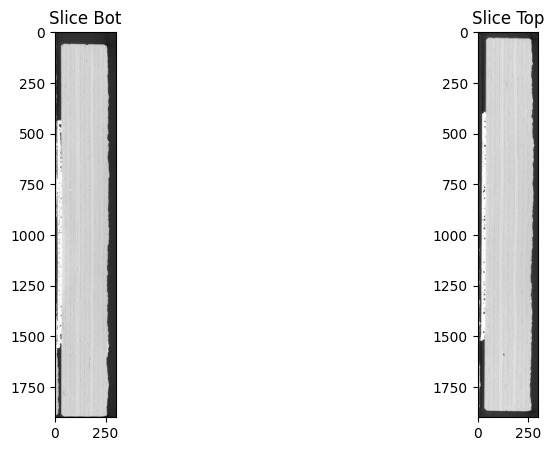

In [59]:
# plot the slices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(bot[i], cmap="gray")
ax[0].set_title("Slice Bot")
ax[1].imshow(top[j], cmap="gray")
ax[1].set_title("Slice Top")
plt.show()

shift: (28, 296), corr.shape: (1900, 300)


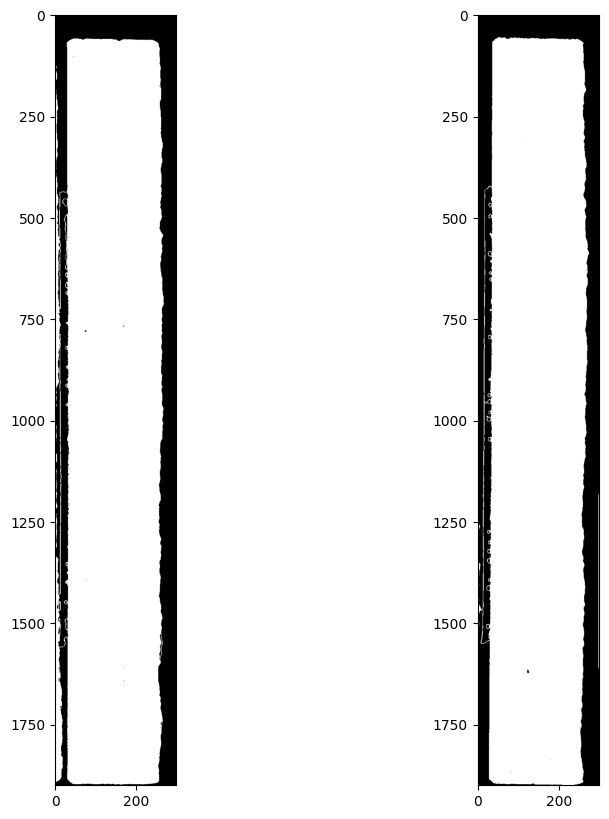

In [60]:
# compute shift between slices
shift = find_shift(bot[i], top[j], show=True, top_threshold=245)

In [51]:
# shift top volume
top_shifted = shift_volume_concurrent(top, shift)

Thresholding: 100%|██████████| 4506/4506 [00:01<00:00, 2844.79it/s]


In [56]:
# concatenate volumes
concatenated = concatenate_volumes(bot, top_shifted, i, j)

In [57]:
# save the concatenated volume
output_folder = Path("C:/Users/alberto.vicente/Documents/temporal/volumenes/5")
write_sequence(output_folder, "concatenated", concatenated)

Saving: 100%|██████████| 7652/7652 [00:21<00:00, 354.47it/s]

Saving complete.
